### Import

In [39]:
#!git clone https://github.com/toelt-llc/ADL-Book-2nd-Ed.git

In [40]:
# inputs to download the dataset
#CACHE_DIR = os.path.join(os.sep, 'tmp', 'radon')
#url_base = 'http://www.stat.columbia.edu/~gelman/arm/examples/radon/'
# Alternative source:
# url_base = ('https://raw.githubusercontent.com/pymc-devs/uq_chapter/master/reference/data/')

#rd = read_data(CACHE_DIR, url_base)
#radon_features, radon_labels, county_name = rd.create_dataset()

In [41]:
# general libraries
#import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import matplotlib.font_manager as fm

# tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling

# ignore warnings
import warnings
warnings.simplefilter('ignore')
import sys
sys.path.append('ADL-Book-2nd-Ed/modules/')

#from read_radon_dataset import read_data
#from style_setting import set_style

### Functions

In [42]:
def download_radon_dataset():
    """Download the radon dataset and read as Pandas dataframe."""
    srrs2 = pd.read_csv('tmp/radon/srrs2.dat')
    srrs2.rename(columns = str.strip, inplace = True)
    cty = pd.read_csv('tmp/radon/cty.dat')
    cty.rename(columns = str.strip, inplace = True)
    return srrs2, cty
def preprocess_radon_dataset(srrs2, cty, state = 'MN'):
    """Preprocess radon dataset as done in "Bayesian Data Analysis" book."""
    srrs2 = srrs2[srrs2.state == state].copy()
    cty = cty[cty.st == state].copy()

    # We will now join datasets on Federal Information Processing Standards
    # (FIPS) id, ie, codes that link geographic units, counties and county
    # equivalents. http://jeffgill.org/Teaching/rpqm_9.pdf
    srrs2['fips'] = 1000 * srrs2.stfips + srrs2.cntyfips
    cty['fips'] = 1000 * cty.stfips + cty.ctfips

    df = srrs2.merge(cty[['fips', 'Uppm']], on='fips')
    df = df.drop_duplicates(subset = 'idnum')
    df = df.rename(index = str, columns = {'Uppm': 'uranium_ppm'})

    # For any missing or invalid activity readings, we'll use a value of `0.1`.
    df['radon'] = df.activity.apply(lambda x: x if x > 0. else 0.1)

    # Remap categories to start from 0 and end at max(category).
    county_name = sorted(df.county.unique())
    df['county'] = df.county.astype(
        pd.api.types.CategoricalDtype(categories = county_name)).cat.codes
    county_name = list(map(str.strip, county_name))

    df['log_uranium_ppm'] = df['uranium_ppm']
    df_features = df[['floor', 'county', 'log_uranium_ppm', 'pcterr']]
    df_labels = df['radon']

    return df_features, df_labels, county_name

def create_dataset():
    """Return the final dataframe with preprocessed data."""
    radon_features, radon_labels, county_name = preprocess_radon_dataset(*download_radon_dataset())

    return radon_features, radon_labels, county_name

def build_model(arg_train_x, arg_learning_rate = 0.001):
    model = keras.Sequential([layers.Dense(1,input_shape = [len(arg_train_x.columns)])])
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = arg_learning_rate)
    model.compile(loss = 'mse',
                optimizer = optimizer,
                metrics = ['mse'])
    return model


In [43]:
def performances_evaluation(arg_model,arg_test_x,arg_test_y):
    test_predictions = arg_model.predict(arg_test_x).flatten() # predict radon activities with the built linear regression model

    # Predictions vs. True Values PLOT
    plt.scatter(arg_test_y, test_predictions, marker = 'o', c = 'blue')
    plt.plot([-5,20], [-5,20], color = 'black', ls = '--')

    plt.ylabel('Predictions [activity]')
    plt.xlabel('True Values [activity]')
    plt.title('Linear Regression with One Neuron')
    plt.ylim(-5, 20)
    plt.xlim(-5, 20)
    plt.axis(True)
    plt.show()

def plt_hist_mse(arg_hist_dict, arg_epoch=600):
    for key in arg_hist_dict:  
        plt.plot(arg_hist_dict[key]['epoch'], arg_hist_dict[key]['mse'],label=key)
    plt.ylabel('Cost Function (MSE)')
    plt.xlabel('Number of Iterations')
    plt.legend(loc='upper right')
    plt.ylim(0, 50)
    plt.xlim(0, arg_epoch)
    plt.axis(True)

    plt.show()

### Datas

In [44]:
radon_features, radon_labels, county_name = create_dataset()
# Dataset Splitting
np.random.seed(48763)
rnd = np.random.rand(len(radon_features)) < 0.8

train_x = radon_features[rnd] # training dataset (features)
train_y = radon_labels[rnd] # training dataset (labels)
test_x = radon_features[~rnd] # testing dataset (features)
test_y = radon_labels[~rnd] # testing dataset (labels)

print('The training dataset dimensions are: ', train_x.shape)
print('The testing dataset dimensions are: ', test_x.shape)

The training dataset dimensions are:  (738, 4)
The testing dataset dimensions are:  (181, 4)


### Exercise1
- Try using only one feature to predict radon activity and see how the results change

In [45]:

e1_EPOCHS = 600
e1_loss_dict={}
e1_model_dict={}
e1_hist_dict={}
model = build_model(train_x)
history = model.fit(
    train_x, train_y,
    epochs = e1_EPOCHS, 
    verbose = 0,
    callbacks = [tfdocs.modeling.EpochDots()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
e1_model_dict['all']=model
e1_hist_dict["all"]=hist
e1_loss_dict["all"]=hist.iloc[-1]['loss']

for column in train_x.columns:
    model = build_model(train_x[[column]])
    
    history = model.fit(
        train_x[[column]], train_y,
        epochs = e1_EPOCHS, 
        verbose = 0,
        callbacks = [tfdocs.modeling.EpochDots()])

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    e1_model_dict[column]=model
    e1_hist_dict[column]=hist
    e1_loss_dict[column]=hist.iloc[-1]['loss']
    



Epoch: 0, loss:1166.5310,  mse:1166.5310,  
....................................................................................................
Epoch: 100, loss:25.2406,  mse:25.2406,  
....................................................................................................
Epoch: 200, loss:18.6259,  mse:18.6259,  
....................................................................................................
Epoch: 300, loss:16.9482,  mse:16.9482,  
....................................................................................................
Epoch: 400, loss:16.6939,  mse:16.6939,  
....................................................................................................
Epoch: 500, loss:16.6356,  mse:16.6356,  
....................................................................................................
Epoch: 0, loss:47.9193,  mse:47.9193,  
...................................................................................................

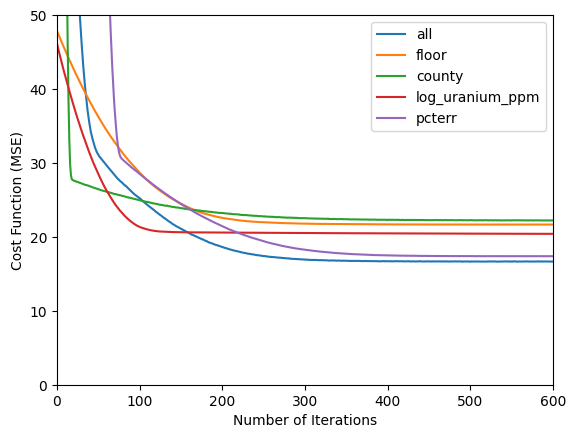

In [46]:
plt_hist_mse(e1_hist_dict)

all
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


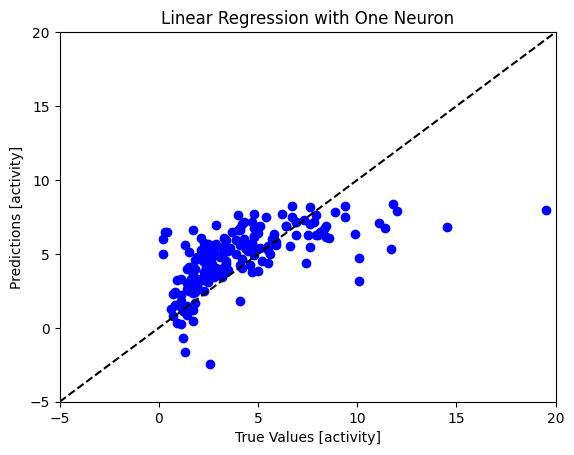

floor
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


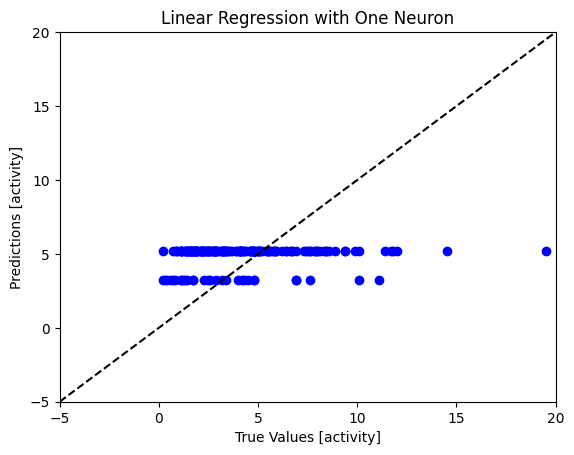

county
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


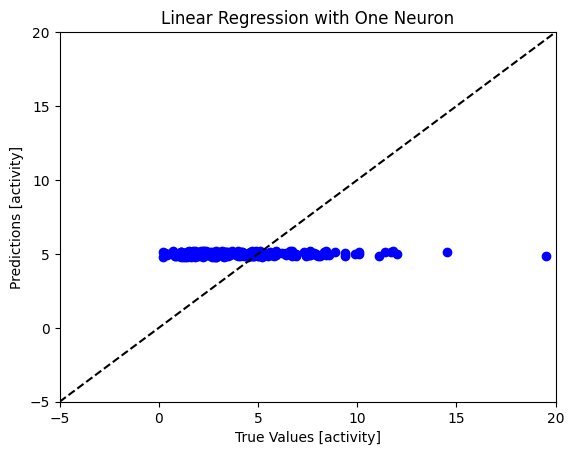

log_uranium_ppm
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


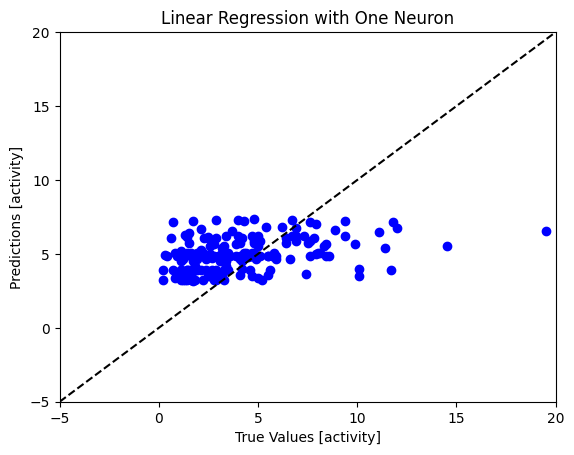

pcterr
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


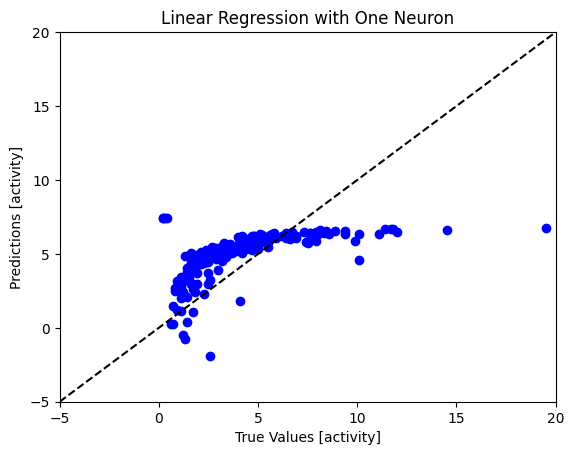

In [47]:
for key in e1_model_dict:
    print(key)
    if key =='all':
        performances_evaluation(e1_model_dict[key],test_x,test_y)
        continue
    performances_evaluation(e1_model_dict[key],test_x[key],test_y)

In [48]:
e1_loss_dict

{'all': 16.65793228149414,
 'floor': 21.6689453125,
 'county': 22.221782684326172,
 'log_uranium_ppm': 20.411130905151367,
 'pcterr': 17.386444091796875}

### Exercise2
- Try to change the `learning_rate` parameter and then observe how the model’s 
convergence changes. 
- Then try to reduce the `EPOCHS` parameter and observe when the model cannot reach convergence.

In [49]:
LR=[0.001, 0.005, 0.01, 0.05]
e21_EPOCHS = 600
e21_loss_dict={}
e21_model_dict={}
e21_hist_dict={}
for lr in LR:
    model = build_model(train_x,lr)
    history = model.fit(
        train_x, train_y,
        epochs = e21_EPOCHS, 
        verbose = 0,
        callbacks = [tfdocs.modeling.EpochDots()])

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    e21_model_dict[lr]=model
    e21_hist_dict[lr]=hist
    e21_loss_dict[lr]=hist.iloc[-1]['loss']


Epoch: 0, loss:526.7154,  mse:526.7154,  
....................................................................................................
Epoch: 100, loss:20.9628,  mse:20.9628,  
....................................................................................................
Epoch: 200, loss:17.4044,  mse:17.4044,  
....................................................................................................
Epoch: 300, loss:16.7996,  mse:16.7996,  
....................................................................................................
Epoch: 400, loss:16.7138,  mse:16.7138,  
....................................................................................................
Epoch: 500, loss:16.7221,  mse:16.7221,  
....................................................................................................
Epoch: 0, loss:136.2014,  mse:136.2014,  
...................................................................................................

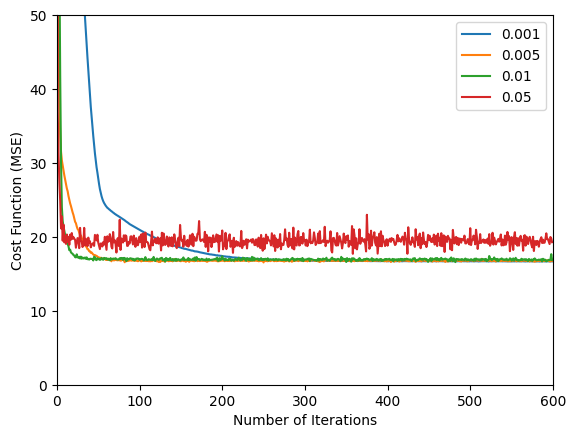

In [50]:
plt_hist_mse(e21_hist_dict)

0.001
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


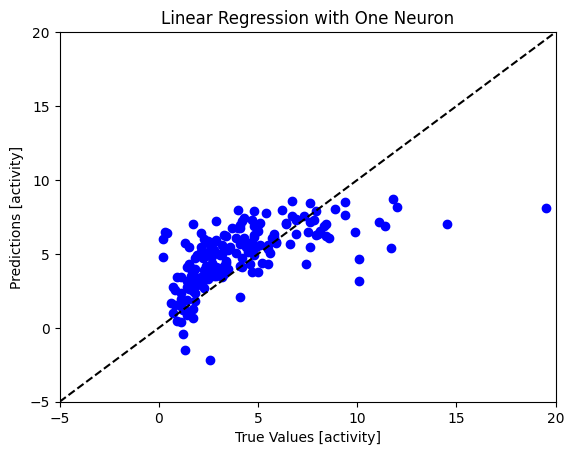

0.005
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


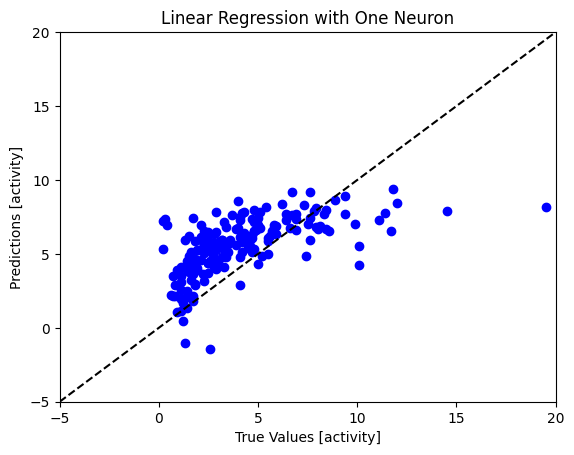

0.01
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


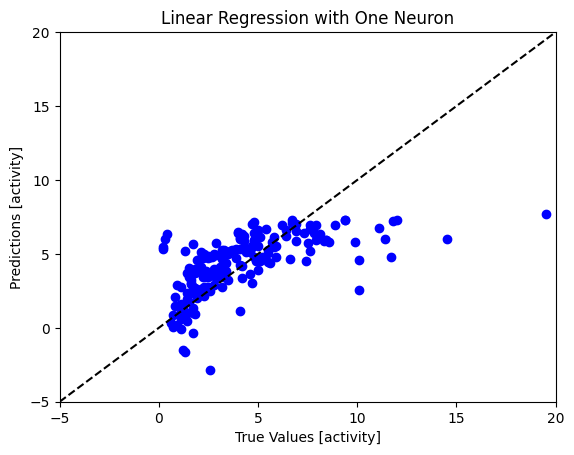

0.05
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


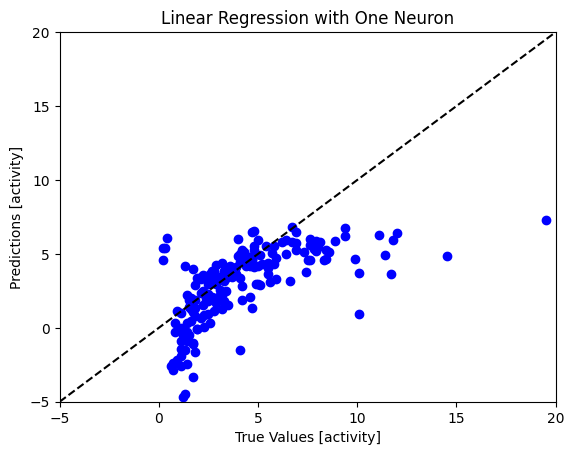

In [51]:
for key in e21_model_dict:
    print(key)
    performances_evaluation(e21_model_dict[key],test_x,test_y)

In [52]:
e21_loss_dict

{0.001: 16.689062118530273,
 0.005: 16.759695053100586,
 0.01: 16.883996963500977,
 0.05: 19.280742645263672}

In [53]:
EP=[600, 300, 150,75]
e22_loss_dict={}
e22_model_dict={}
e22_hist_dict={}
for ep in EP:
    model = build_model(train_x)
    history = model.fit(
        train_x, train_y,
        epochs = ep, 
        verbose = 0,
        callbacks = [tfdocs.modeling.EpochDots()])

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    e22_model_dict[ep]=model
    e22_hist_dict[ep]=hist
    e22_loss_dict[ep]=hist.iloc[-1]['loss']


Epoch: 0, loss:211.2439,  mse:211.2439,  
....................................................................................................
Epoch: 100, loss:20.3722,  mse:20.3722,  
....................................................................................................
Epoch: 200, loss:17.3035,  mse:17.3035,  
....................................................................................................
Epoch: 300, loss:16.7735,  mse:16.7735,  
....................................................................................................
Epoch: 400, loss:16.7217,  mse:16.7217,  
....................................................................................................
Epoch: 500, loss:16.6862,  mse:16.6862,  
....................................................................................................
Epoch: 0, loss:642.6141,  mse:642.6141,  
...................................................................................................

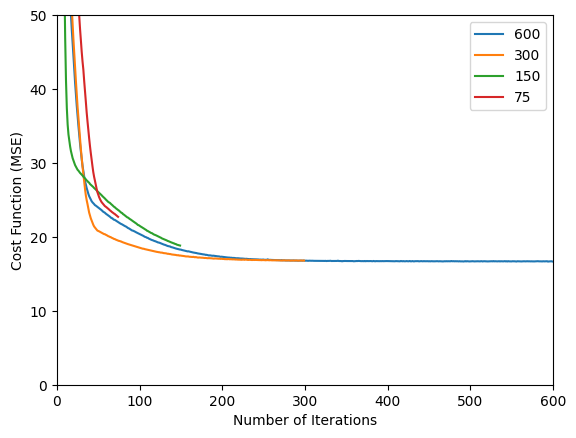

In [54]:
plt_hist_mse(e22_hist_dict)

600
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


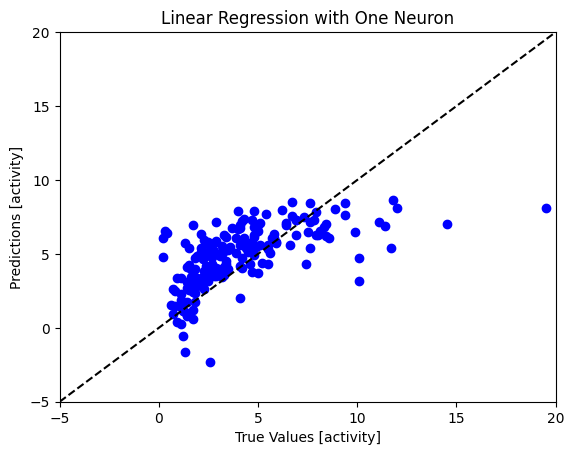

300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


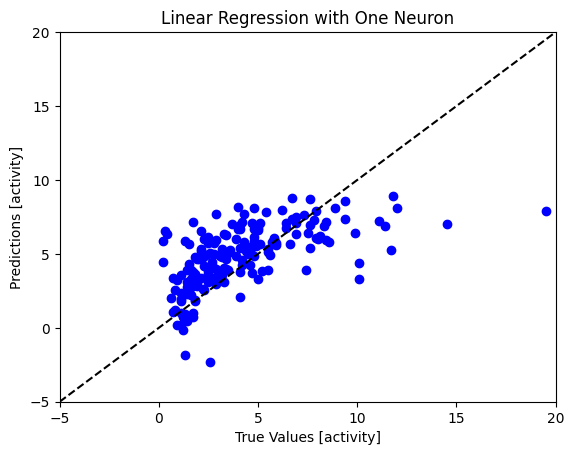

150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


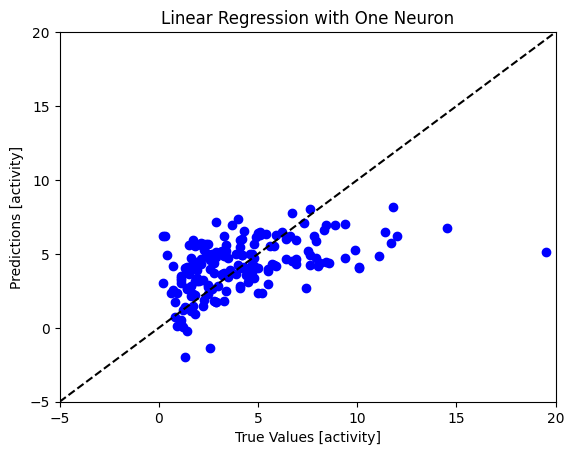

75
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


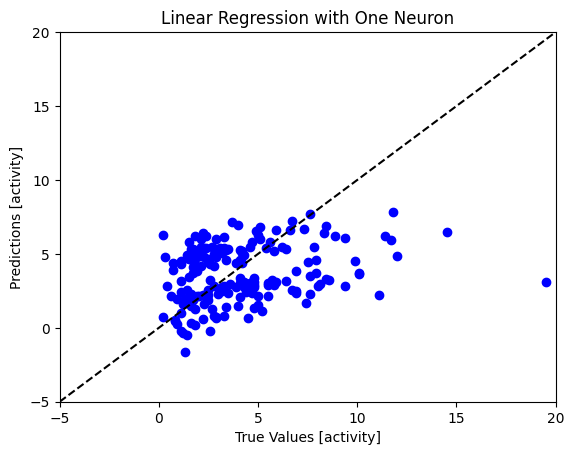

In [55]:
for key in e22_model_dict:
    print(key)
    performances_evaluation(e22_model_dict[key],test_x,test_y)

In [56]:
e22_loss_dict

{600: 16.67522430419922,
 300: 16.795856475830078,
 150: 18.828229904174805,
 75: 22.715200424194336}

### Exercise3
- Try to see how a model’s results change based on the training dataset’s size (reduce it and use 
different sizes, comparing the results).

In [57]:
len(train_x)

738

In [61]:
np.random.seed(48763)

RT=[0.763, 0.48763, 0.25, 0.1]
e3_EPOCHS = 1000
e3_loss_dict={}
e3_model_dict={}
e3_hist_dict={}
for rt in RT:
    rnd = np.random.rand(len(train_x)) < rt
    model = build_model(train_x[rnd])
    history = model.fit(
        train_x[rnd], train_y[rnd],
        epochs = e3_EPOCHS, 
        verbose = 0,
        callbacks = [tfdocs.modeling.EpochDots()])

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    e3_model_dict[len(train_x[rnd])]=model
    e3_hist_dict[len(train_x[rnd])]=hist
    e3_loss_dict[len(train_x[rnd])]=hist.iloc[-1]['loss']


Epoch: 0, loss:56.8490,  mse:56.8490,  
....................................................................................................
Epoch: 100, loss:21.9255,  mse:21.9255,  
....................................................................................................
Epoch: 200, loss:17.1394,  mse:17.1394,  
....................................................................................................
Epoch: 300, loss:15.6930,  mse:15.6930,  
....................................................................................................
Epoch: 400, loss:15.4186,  mse:15.4186,  
....................................................................................................
Epoch: 500, loss:15.3763,  mse:15.3763,  
....................................................................................................
Epoch: 600, loss:15.3873,  mse:15.3873,  
....................................................................................................


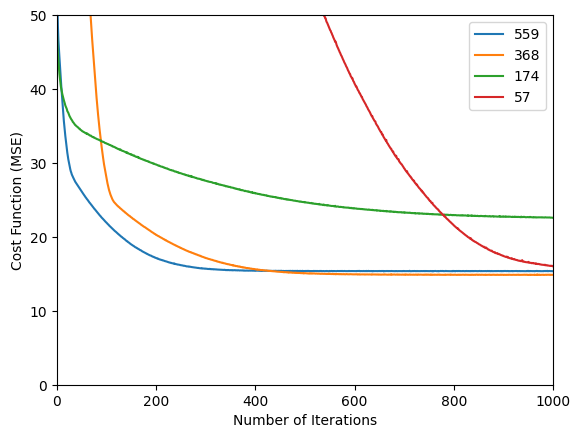

In [62]:
plt_hist_mse(e3_hist_dict,e3_EPOCHS)

559
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


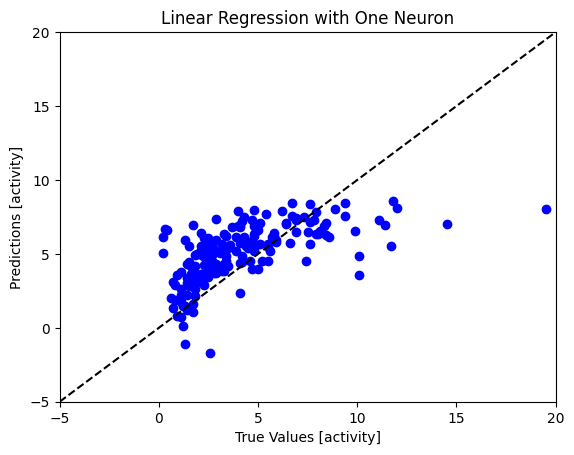

368
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


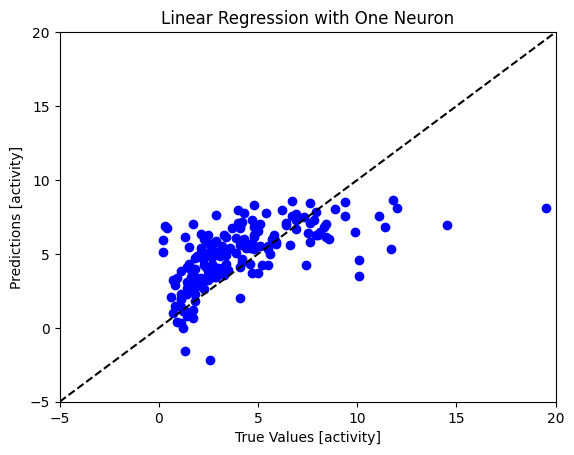

174
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


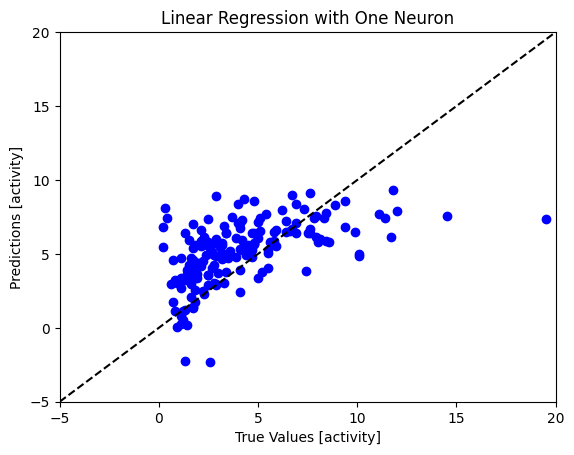

57
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


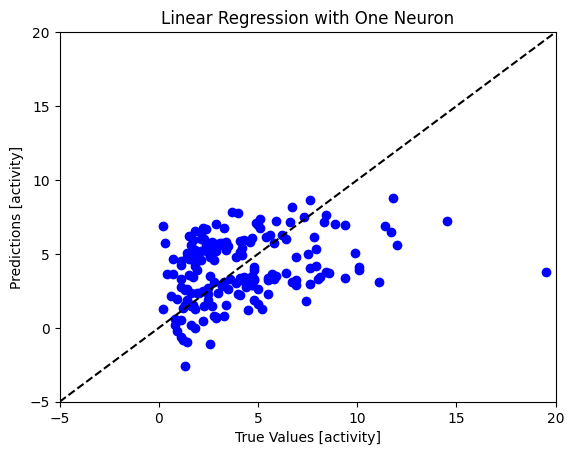

In [63]:
for key in e3_model_dict:
    print(key)
    performances_evaluation(e3_model_dict[key],test_x,test_y)

In [64]:
e3_loss_dict

{559: 15.36280632019043,
 368: 14.869524955749512,
 174: 22.59147071838379,
 57: 16.05425453186035}